# 인물 모드 카메라 앱 만들기

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/AIFFEL
!pwd
!mkdir -p work/human_segmentation/models
!mkdir -p work/human_segmentation/images

/content/drive/MyDrive/AIFFEL
/content/drive/MyDrive/AIFFEL


In [26]:
! pip install opencv-python pixellib # 다시 시작이 요구될 수 있습니다.

## 인물모드 카메라 앱 만들기

이미지 크기: (4672, 7008, 3)


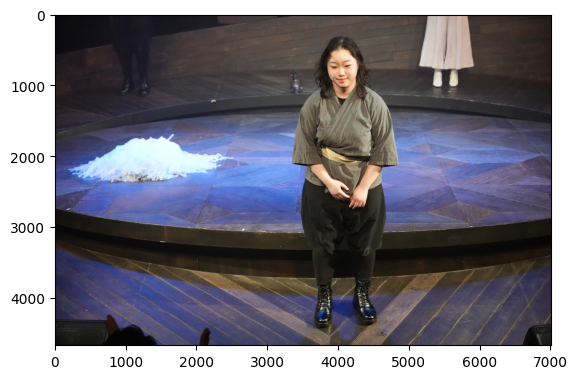

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

home_dir = './'
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_img1.jpg")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

model = deeplabv3_resnet101(pretrained=True).eval()
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [28]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

CPU times: user 15.1 s, sys: 197 ms, total: 15.3 s
Wall time: 36.3 s


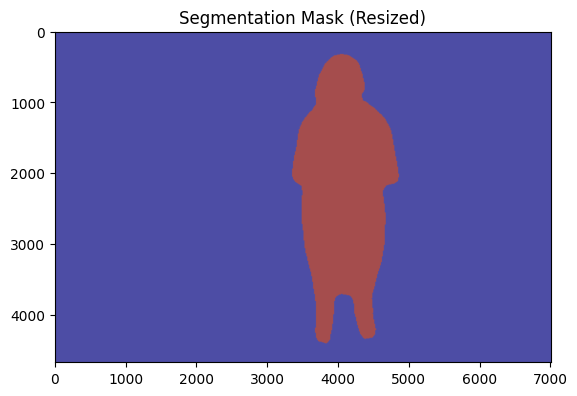

background
person
[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]


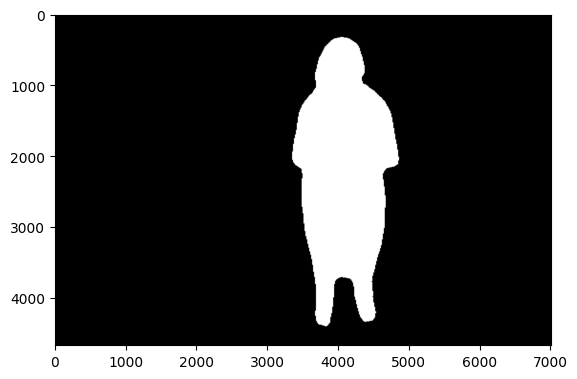

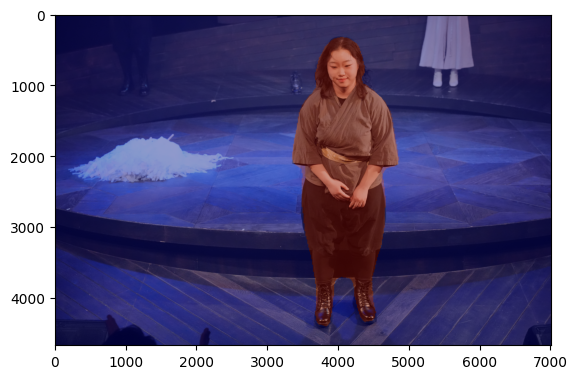

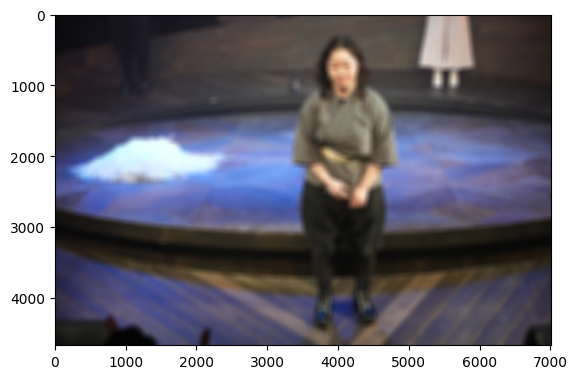

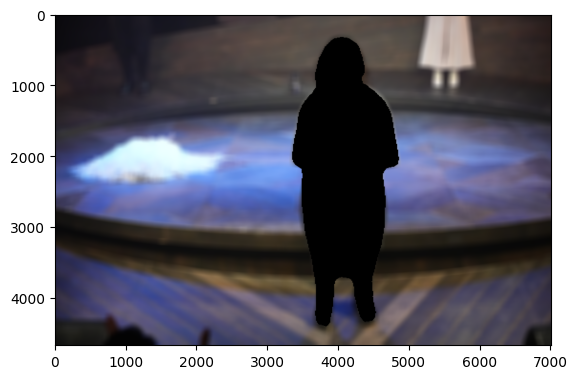

원본 이미지


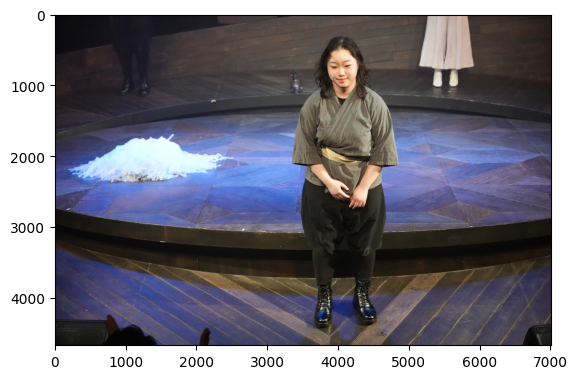

블러 이미지


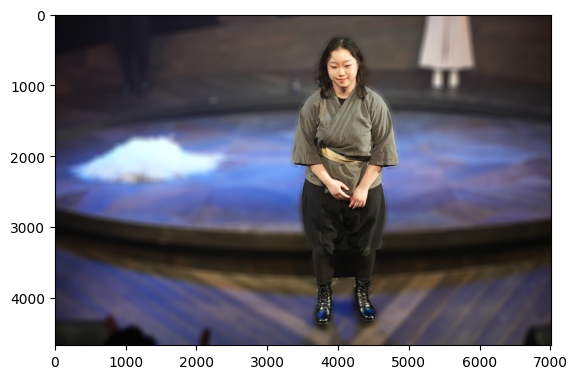

사람 블러 이미지


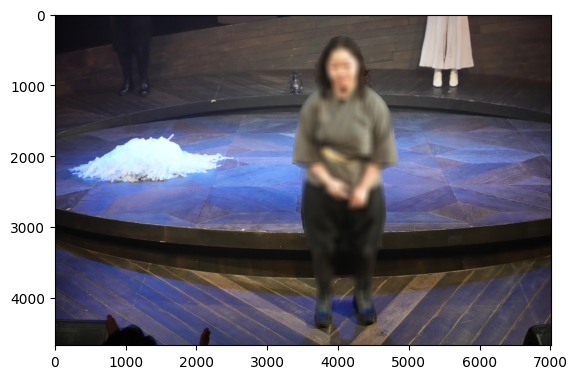

In [29]:
# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

unique_classes = np.unique(output_predictions_resized)
unique_classes

for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])  # 생성한 20개의 컬러맵 출력

seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (101, 101))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
print("원본 이미지")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

print("블러 이미지")
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

print("사람 블러 이미지")
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 인물모드 카메라 앱 만들기 - 다른 사진으로 테스트

이미지 크기: (7008, 4672, 3)


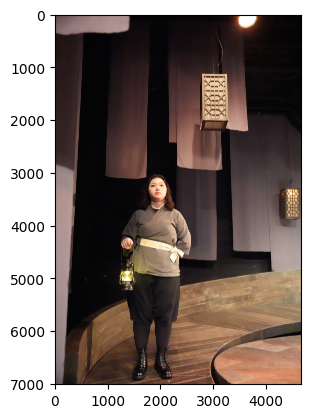

In [30]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

home_dir = './'
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_img2.jpg")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

model = deeplabv3_resnet101(pretrained=True).eval()
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [31]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

CPU times: user 11 s, sys: 75 ms, total: 11.1 s
Wall time: 11.2 s


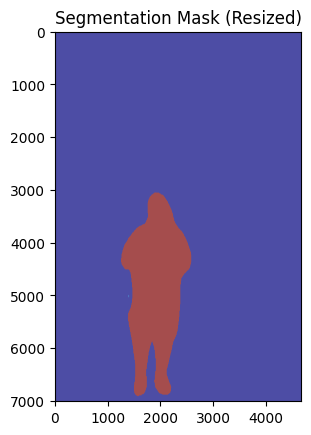

background
bottle
person
[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]


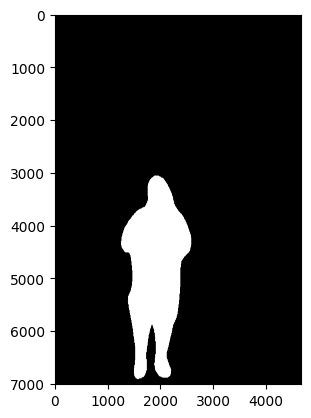

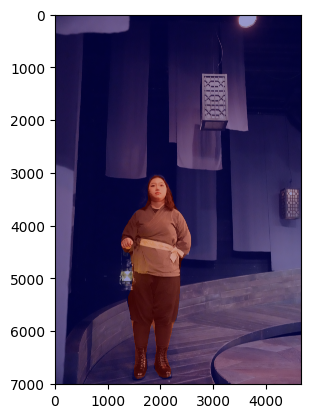

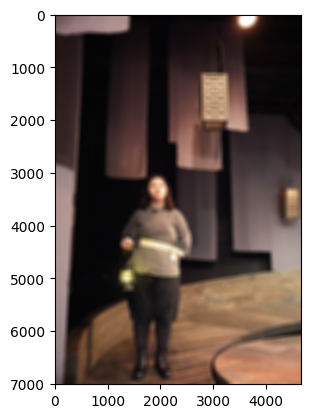

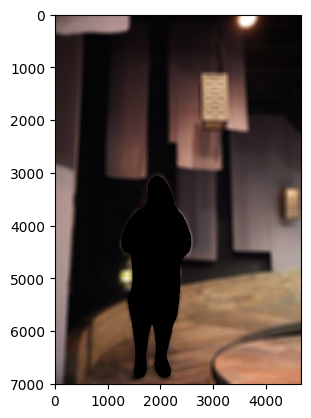

원본 이미지


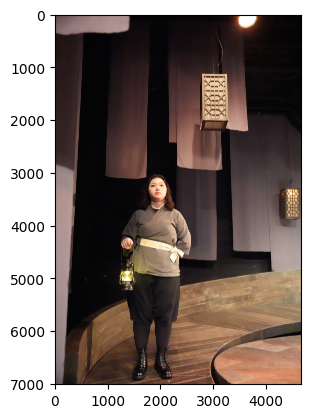

블러 이미지


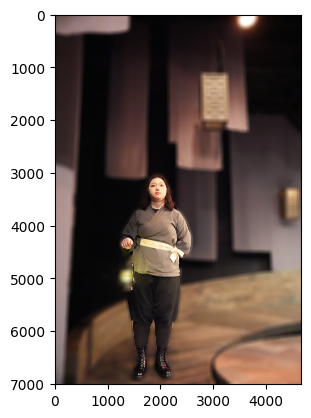

사람 블러 이미지


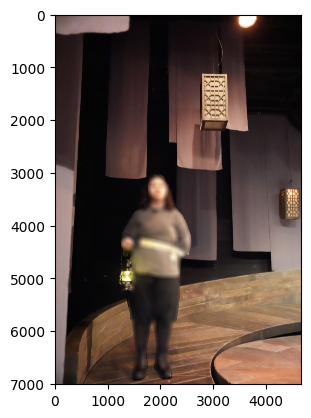

In [32]:
# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

unique_classes = np.unique(output_predictions_resized)
unique_classes

for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])  # 생성한 20개의 컬러맵 출력

seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (101, 101))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
print("원본 이미지")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

print("블러 이미지")
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

print("사람 블러 이미지")
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 전체 과정을 하나의 함수로 만들기

In [49]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

def segment_person_and_show(
    input_image_path: str,
    output_person_blur_path: str,
    output_background_blur_path: str,
    blur_kernel_size: int = 101
):
    """
    DeepLabv3-ResNet101을 매번 새로 불러서 사람/배경 분리 후
    1) 사람만 블러(배경 선명)
    2) 배경만 블러(사람 선명)
    두 결과를 저장하고, 동시에 화면에 출력합니다.
    """
    assert os.path.exists(input_image_path), f"입력 이미지가 없습니다: {input_image_path}"

    # ----- 1. 모델 로드 -----
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = deeplabv3_resnet101(pretrained=True).to(device).eval()
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    # ----- 2. 이미지 로드 -----
    img_bgr = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError("이미지를 읽을 수 없습니다.")
    h, w = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    inp = transform(img_rgb).unsqueeze(0).to(device)

    # ----- 3. 세그멘테이션 -----
    with torch.no_grad():
        out = model(inp)["out"][0]
        pred = out.argmax(0).byte().cpu().numpy()
    pred_resized = cv2.resize(pred, (w, h), interpolation=cv2.INTER_NEAREST)

    # ----- 4. 마스크 처리 -----
    person_id = 15  # PASCAL VOC person
    mask_gray = (pred_resized == person_id).astype(np.uint8) * 255
    mask_color = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGR)

    # ----- 5. 블러 처리 -----
    if blur_kernel_size < 1:
        blur_kernel_size = 1
    if blur_kernel_size % 2 == 0:
        blur_kernel_size += 1
    img_blur = cv2.blur(img_bgr, (blur_kernel_size, blur_kernel_size))

    # ----- 6. 결과 합성 -----
    out_person_blur = np.where(mask_color == 255, img_blur, img_bgr)  # 사람 블러
    out_background_blur = np.where(mask_color == 255, img_bgr, img_blur)  # 배경 블러

    # ----- 7. 결과 저장 -----
    cv2.imwrite(output_person_blur_path, out_person_blur)
    cv2.imwrite(output_background_blur_path, out_background_blur)

    # ----- 8. 결과 출력 -----
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(out_person_blur, cv2.COLOR_BGR2RGB))
    plt.title("Person Blurr")
    plt.axis("off")

    # 원본과의 비교를 위해 가운데에 원본 이미지 출력
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(out_background_blur, cv2.COLOR_BGR2RGB))
    plt.title("Background Blurr")
    plt.axis("off")

    plt.show()

    print("✅ 결과 저장 완료!")
    print(f" - 사람 블러: {output_person_blur_path}")
    print(f" - 배경 블러: {output_background_blur_path}")

    return None

In [51]:
# 두 개의 이미지에 대해서 블러 커널 사이즈를 바꿔가면서 변화 관찰
# 10씩 증가시키는 것은 실제로 시도해 봤을 때 변화가 크지 않아서 적당히 변화를 확인할 수 있는 값으로 배열 생성 후 반복 실행
# 두 이미지 모두 101, 201 정도가 자연스럽게 합성됨

blur_kernels = [5, 13, 51, 101, 201, 501, 1001]

base_path = './work/human_segmentation/images/'

for i in range(1, 3):
    for bk in blur_kernels:
        img_path = f"{base_path}my_img{i}.jpg"
        person_blur_path = f"{base_path}/results/person_blur{bk}_my_img{i}.jpg"
        background_blur_path = f"{base_path}/results/background_blur{bk}_my_img{i}.jpg"

        print(f"Image Name: my_img{i}")
        print(f"Blur Kernel Size: {bk}")

        segment_person_and_show(
            input_image_path=img_path,
            output_person_blur_path=person_blur_path,
            output_background_blur_path=background_blur_path,
            blur_kernel_size=bk
        )


Output hidden; open in https://colab.research.google.com to view.

## 고양이와 사막 이미지 합성하기

In [35]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (183, 275, 3)
배경(사막) 이미지 크기: (183, 275, 3)


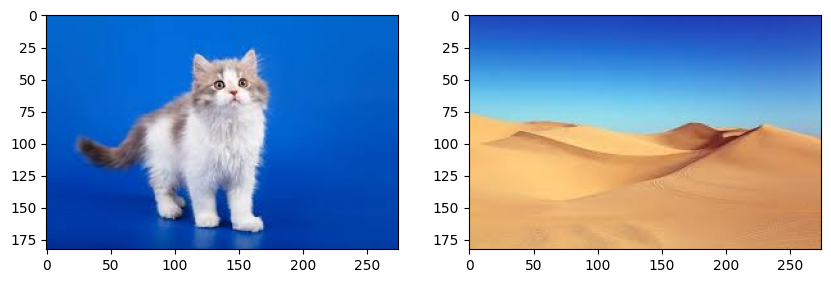

In [36]:
home_dir = './work/human_segmentation/images/'
cat_img_file = "cat.jpg"  # 고양이 이미지를 준비해주세요
sand_img_file = "sand.jpg"  # 사막 이미지를 준비해주세요
cat_img_path = os.path.join(home_dir, cat_img_file)
sand_img_path = os.path.join(home_dir, sand_img_file)

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [37]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [38]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (183, 275)


In [39]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


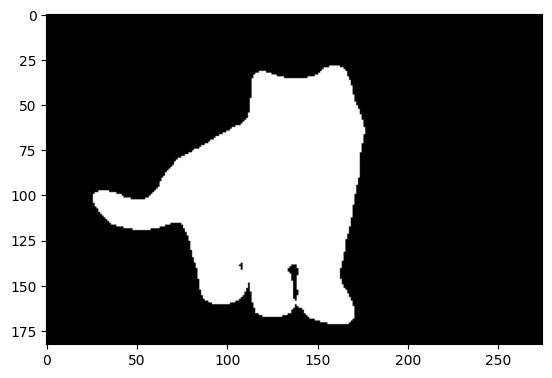

In [40]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

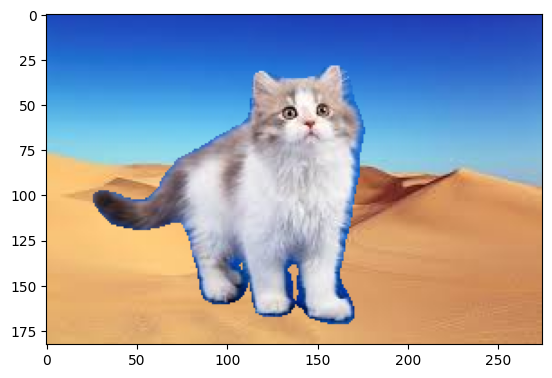

In [41]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

# 인물 모드 문제점 찾기

## 사진에서 문제점 찾기

![](https://drive.google.com/uc?export=view&id=16Mri7nIhSvXZoolEgKyS6vrA9mwTrqRw)

## 해결 방법 제안해 보기

1. 모델 로드/전처리 개선
    - 가중치 선언 변경: 경고 제거 & 라벨 일관성 확보
    - 비율 유지 리사이즈 & 패딩(Letterbox): 마스크 왜곡 최소화
    - 한 번만 모델 로드(캐시): 반복 호출 시 속도 개선

2. 마스크 후처리(경계 부드럽게 + 구멍 메우기)
    - 형태학 연산(Closing→Opening)으로 소소한 잡음 제거
    - Guided Filter / Bilateral Filter 기반 소프트 알파로 자연스러운 Feathering

3. 합성/블러 품질 개선
    - Gaussian 또는 Bilateral 블러 사용 (박스 블러보다 자연스러움)
    - 알파 블렌딩으로 경계 후광 최소화
    - 저장 폴더 생성 보장

경계가 자연스러워지고, 마스크 왜곡이 줄며, 실행 속도 개선

In [52]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from PIL import Image


# --- 글로벌 캐시 ---
_DEEPLAB = None
_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def get_model():
    global _DEEPLAB
    if _DEEPLAB is None:
        weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
        _DEEPLAB = deeplabv3_resnet101(weights=weights).to(_DEVICE).eval()
    return _DEEPLAB

def resize_with_letterbox(img_rgb, short=520):
    h, w = img_rgb.shape[:2]
    scale = short / min(h, w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    resized = cv2.resize(img_rgb, (nw, nh), interpolation=cv2.INTER_LINEAR)
    # pad to multiple of 32 (segmentation/backbone downsample 안정성)
    th = ((nh + 31)//32)*32
    tw = ((nw + 31)//32)*32
    top = (th - nh)//2; bottom = th - nh - top
    left = (tw - nw)//2; right = tw - nw - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))
    meta = dict(scale=scale, pad=(left, top), orig=(h, w), padded=(th, tw))
    return padded, meta


In [53]:
def refine_mask_soft(mask_uint8, guidance_bgr, ks=5):
    # 형태학적 후처리
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks, ks))
    mask = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
    # 가장자리 feather (거리변환 기반 소프트 알파)
    dist = cv2.distanceTransform((mask>0).astype(np.uint8), cv2.DIST_L2, 3)
    dist = dist / (dist.max() + 1e-6)
    soft = np.clip(dist*1.5, 0, 1)  # feather 강도 조절
    # 경계 보정: 가이드 필터(빠른 대체: bilateral)
    soft = cv2.bilateralFilter((soft*255).astype(np.uint8), d=5, sigmaColor=25, sigmaSpace=25)
    soft = soft.astype(np.float32)/255.0
    return np.clip(soft, 0.0, 1.0)


In [54]:
def safe_imwrite(path, img):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, img)

def gaussian_kernel_size(k):
    # 홀수 강제 & 과도한 값 제한
    k = max(1, k)
    if k % 2 == 0: k += 1
    return min(k, 151)  # 과도한 값 방지

def composite_alpha(fg_bgr, bg_bgr, alpha):  # alpha: 0~1 float, HxW
    a = alpha[..., None]
    out = (fg_bgr.astype(np.float32)*a + bg_bgr.astype(np.float32)*(1.0 - a))
    return np.clip(out, 0, 255).astype(np.uint8)


In [55]:
def segment_person_and_show(
    input_image_path: str,
    output_person_blur_path: str,
    output_background_blur_path: str,
    blur_kernel_size: int = 101
):
    assert os.path.exists(input_image_path), f"입력 이미지가 없습니다: {input_image_path}"
    model = get_model()

    # 1) 이미지 로드 + 비율 유지 리사이즈
    img_bgr = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError("이미지를 읽을 수 없습니다.")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    padded_rgb, meta = resize_with_letterbox(img_rgb, short=520)

    # 2) 변환 (가중치 권장 전처리)
    weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
    preprocess = weights.transforms()
    inp = preprocess(Image.fromarray(padded_rgb)).unsqueeze(0).to(_DEVICE)

    # 3) 추론
    with torch.inference_mode():
        out = model(inp)["out"][0].argmax(0).byte().cpu().numpy()

    # 4) Letterbox 역보정 → 원본 크기 복원
    left, top = meta["pad"]
    th, tw = meta["padded"]
    cropped = out[top:th-top, left:tw-left]
    # 원본으로 최근접 리사이즈 (라벨 보존)
    h, w = img_bgr.shape[:2]
    pred_resized = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_NEAREST)

    # 5) 마스크 생성/정제
    PERSON_ID = 15  # VOC 매핑 기준
    mask = (pred_resized == PERSON_ID).astype(np.uint8)*255
    alpha = refine_mask_soft(mask, img_bgr, ks=5)  # 0~1

    # 6) 블러 생성 (Gaussian 권장)
    k = gaussian_kernel_size(blur_kernel_size)
    blurred = cv2.GaussianBlur(img_bgr, (k, k), sigmaX=0)

    # 7) 합성
    person_blur    = composite_alpha(blurred, img_bgr, alpha)     # 사람만 블러
    background_blur= composite_alpha(img_bgr, blurred, alpha)     # 배경만 블러

    # 8) 저장/표시
    safe_imwrite(output_person_blur_path, person_blur)
    safe_imwrite(output_background_blur_path, background_blur)

    plt.figure(figsize=(12, 6))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(person_blur, cv2.COLOR_BGR2RGB)); plt.title("Person Blur"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img_bgr,     cv2.COLOR_BGR2RGB)); plt.title("Original");    plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(background_blur, cv2.COLOR_BGR2RGB)); plt.title("Background Blur"); plt.axis("off")
    plt.show()

    print("✅ 결과 저장 완료!")

Image Name: my_img1
Blur Kernel Size: 101


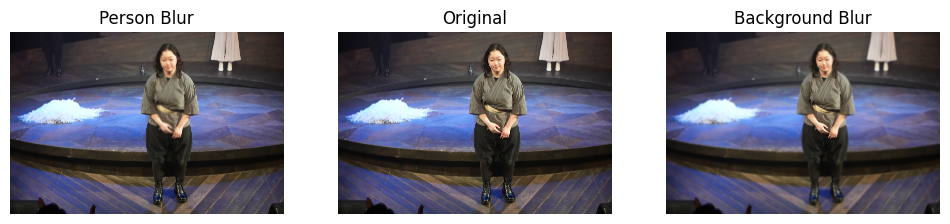

✅ 결과 저장 완료!
Image Name: my_img2
Blur Kernel Size: 101


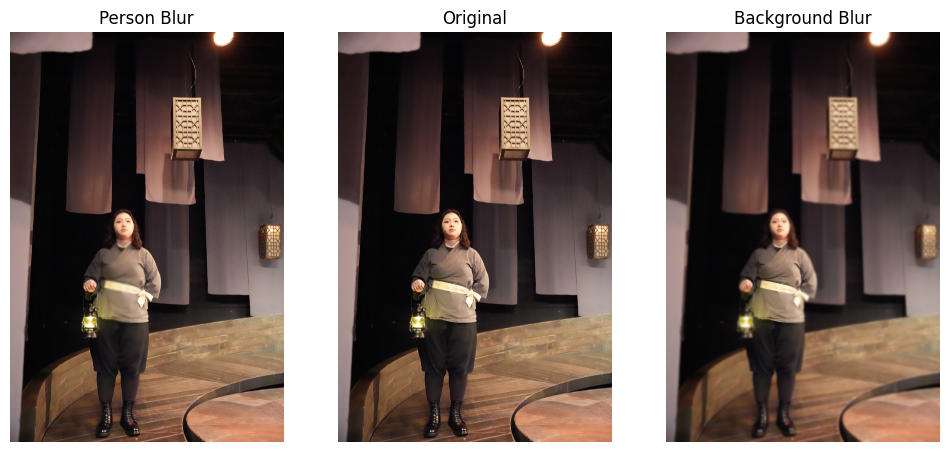

✅ 결과 저장 완료!


In [56]:
blur_kernels = [101]
base_path = './work/human_segmentation/images/'

for i in range(1, 3):
    for bk in blur_kernels:
        img_path = f"{base_path}my_img{i}.jpg"
        person_blur_path = f"{base_path}/results/person_blur{bk}_my_img{i}_2.jpg"
        background_blur_path = f"{base_path}/results/background_blur{bk}_my_img{i}_2.jpg"

        print(f"Image Name: my_img{i}")
        print(f"Blur Kernel Size: {bk}")

        segment_person_and_show(
            input_image_path=img_path,
            output_person_blur_path=person_blur_path,
            output_background_blur_path=background_blur_path,
            blur_kernel_size=bk
        )

In [57]:
import cv2
import matplotlib.pyplot as plt

def compare_segmentation_results(before_person_path: str,
                                 before_bg_path: str,
                                 after_person_path: str,
                                 after_bg_path: str,
                                 original_path: str):
    """
    개선 전/후 세그멘테이션 및 블러 결과를 비교 시각화합니다.
    - 사람 블러(전/후)
    - 원본
    - 배경 블러(전/후)
    """

    # --- 이미지 로드 ---
    img_before_person = cv2.imread(before_person_path)
    img_before_bg = cv2.imread(before_bg_path)
    img_after_person = cv2.imread(after_person_path)
    img_after_bg = cv2.imread(after_bg_path)
    img_original = cv2.imread(original_path)

    if any(x is None for x in [img_before_person, img_before_bg, img_after_person, img_after_bg, img_original]):
        raise ValueError("이미지 중 일부를 불러오지 못했습니다. 경로를 확인하세요.")

    # --- BGR → RGB 변환 ---
    img_before_person = cv2.cvtColor(img_before_person, cv2.COLOR_BGR2RGB)
    img_before_bg = cv2.cvtColor(img_before_bg, cv2.COLOR_BGR2RGB)
    img_after_person = cv2.cvtColor(img_after_person, cv2.COLOR_BGR2RGB)
    img_after_bg = cv2.cvtColor(img_after_bg, cv2.COLOR_BGR2RGB)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # --- 시각화 ---
    plt.figure(figsize=(15, 8))
    plt.suptitle("Before vs After Segmentation & Blur Comparison", fontsize=16, fontweight="bold")

    # 1행: 사람 블러 비교
    plt.subplot(2, 3, 1)
    plt.imshow(img_before_person)
    plt.title("Before: Person Blur")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(img_original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(img_after_person)
    plt.title("After: Person Blur")
    plt.axis("off")

    # 2행: 배경 블러 비교
    plt.subplot(2, 3, 4)
    plt.imshow(img_before_bg)
    plt.title("Before: Background Blur")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(img_original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(img_after_bg)
    plt.title("After: Background Blur")
    plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


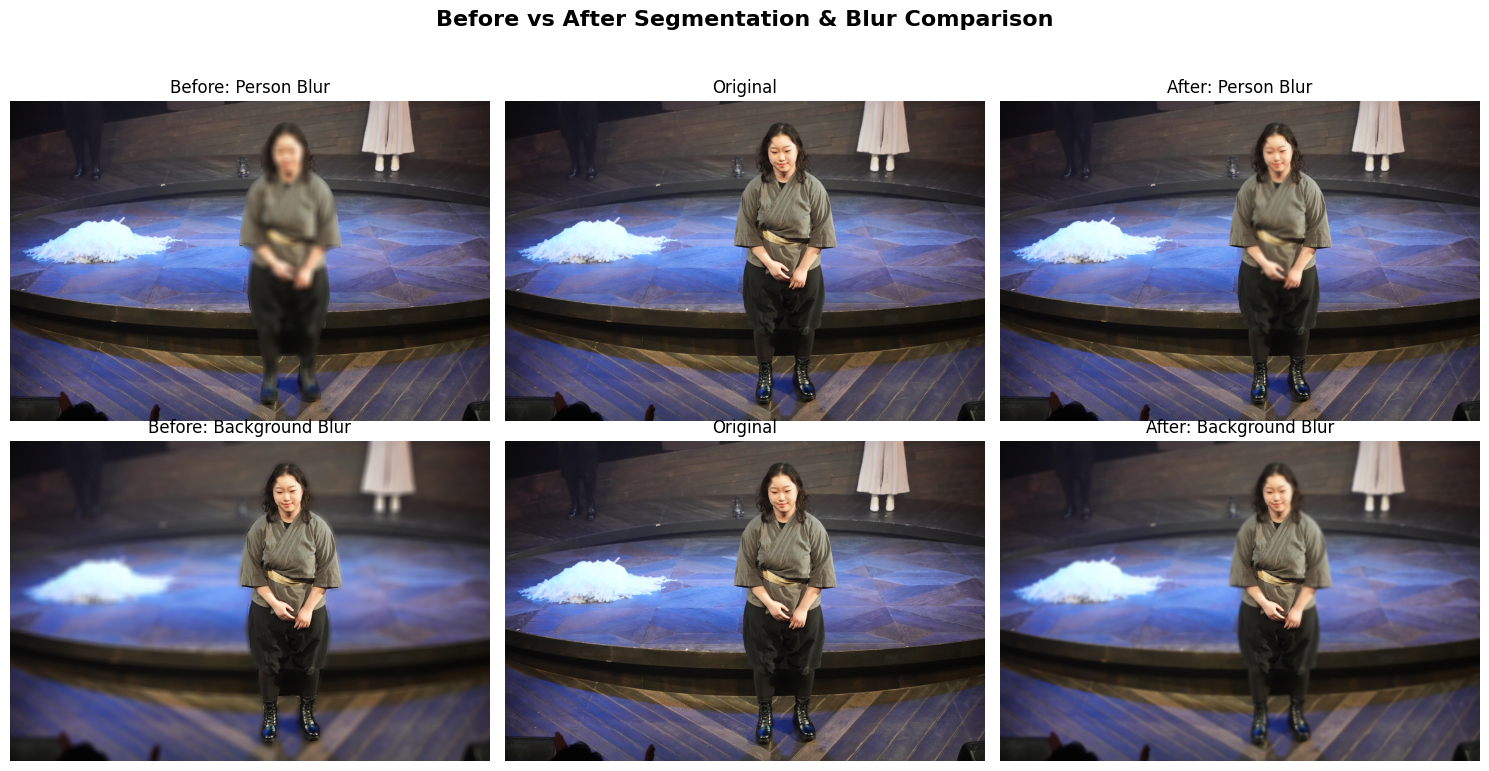

In [58]:
compare_segmentation_results(
    before_person_path="./work/human_segmentation/images/results/person_blur101_my_img1.jpg",
    before_bg_path="./work/human_segmentation/images/results/background_blur101_my_img1.jpg",
    after_person_path="./work/human_segmentation/images/results/person_blur101_my_img1_2.jpg",
    after_bg_path="./work/human_segmentation/images/results/background_blur101_my_img1_2.jpg",
    original_path="./work/human_segmentation/images/my_img1.jpg"
)

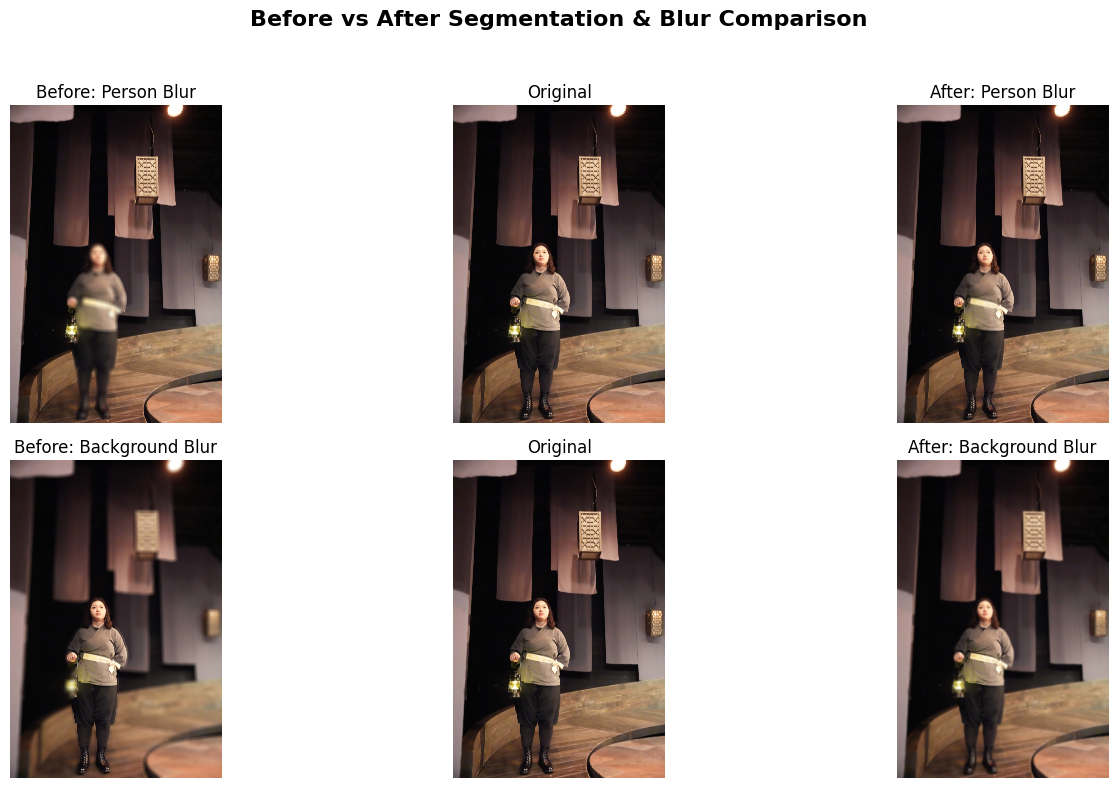

In [59]:
compare_segmentation_results(
    before_person_path="./work/human_segmentation/images/results/person_blur101_my_img2.jpg",
    before_bg_path="./work/human_segmentation/images/results/background_blur101_my_img2.jpg",
    after_person_path="./work/human_segmentation/images/results/person_blur101_my_img2_2.jpg",
    after_bg_path="./work/human_segmentation/images/results/background_blur101_my_img2_2.jpg",
    original_path="./work/human_segmentation/images/my_img2.jpg"
)

코드 실행 결과 경계는 자연스러워졌으나 오히려 흐림효과 적용 범위가 줄어들어 사람이 선명해지지 않는 문제가 발생함.

추가 실험 진행 혹은 새로운 모델을 적용하여 추가로 진행해보고 싶다.